In [1]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [2]:
import sys
sys.path.insert(0,'../src/')
from curve import *
from utils import *
from multiply_connected_pipe import MultiplyConnectedPipe
import numpy as np
import pickle
from matplotlib import pyplot as plt
import scipy as sp
from mat_vec import mat_vec_constructor
from scipy.sparse.linalg import gmres, LinearOperator


In [3]:
with open('./pipes_and_shifts.pickle','rb') as f:
    pipes, shifts = pickle.load(f)

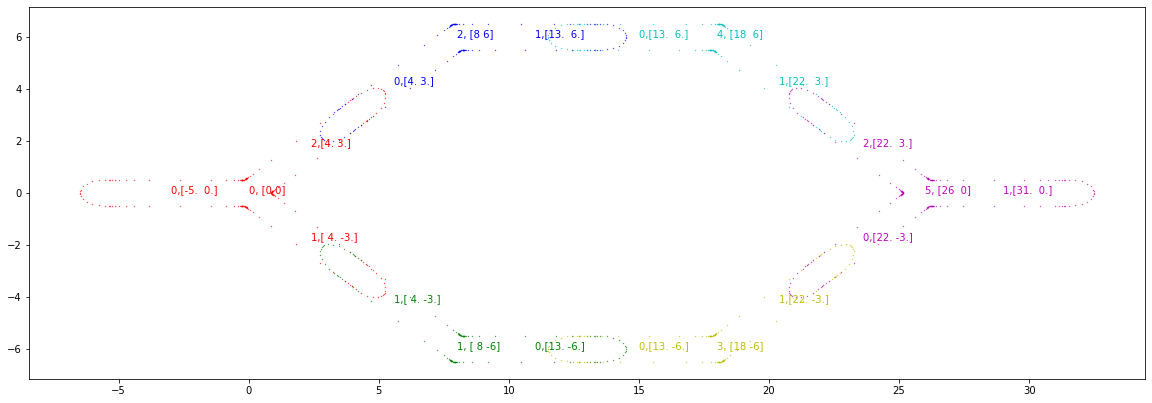

In [4]:
color = ['r','g','b','y','c','m','k']

fig,ax = plt.subplots(figsize=(20,10))
ax.set_aspect('equal')

for a,i,j,c in zip(range(10),pipes,shifts,color):
    panel_break_pts = np.array([cplx2pt(p.start_pt) + j for p in i.panels])
    ax.scatter(panel_break_pts[:,0], panel_break_pts[:,1],c=c,s=0.1)
    for k,let in enumerate(i.lets):
        ax.text(*(0.6*let.matching_pt + j),f'{k},{let.matching_pt + j}',color=c)
    ax.text(*j,f'{a}, {j}',color=c)

In [5]:
pipe = pipes[0]
panels = pipe.panels
pairs = pipe.mat_vec.close_panel_interactions
pipe.mat_vec.build_k()

In [6]:
for p in panels:
    p._build(eng)

In [138]:
k1_correction_sparse = sp.sparse.lil_matrix((len(pipe.t), len(pipe.t)), dtype=np.complex128)
k2_correction_sparse = sp.sparse.lil_matrix((len(pipe.t), len(pipe.t)), dtype=np.complex128)

for i,(p, targets_index) in enumerate(zip(panels,pairs)):
    
    panel_index_start = i*p.n
    panel_index_end = (i+1)*p.n
    targets_index = np.arange(panel_index_start, panel_index_end)
    targets = pipe.t[targets_index]
    
    if isinstance(p.parent, Cap) or isinstance(p.parent, Line):
        pass
    
    k1,k2 = p._build_for_targets(targets, eng)
    
    for i1,i2 in enumerate(targets_index):

        k1_correction_sparse[i2,panel_index_start:panel_index_end] = k1[i1] - pipe.mat_vec.K1[i2,panel_index_start:panel_index_end]
        k2_correction_sparse[i2,panel_index_start:panel_index_end] = k2[i1] - pipe.mat_vec.K2[i2,panel_index_start:panel_index_end]
    
    # k1_ = pipe.mat_vec.K1[targets_index,panel_index_start:panel_index_end]
    # k1 = k1-np.eye(p.n)
    # a = np.linalg.norm(k1)
    # b = np.linalg.norm(k1_)
    # c = np.linalg.norm(k1 - k1_)
    # ratio = c/a if c!=0 else 0
    
    # print(i,a, b, ratio, (str(p.parent.__class__)).split('.')[-1].split("'")[0], sep='\t')
    
    # k2_ = pipe.mat_vec.K2[targets_index,panel_index_start:panel_index_end]

    # if i==38: break

    # a = np.linalg.norm(k2)
    # b = np.linalg.norm(k2_)
    # c = np.linalg.norm(k2 - k2_)
    
    # ratio = c/b if c!=0 else 0
    
    # if c > a/2:
    #     print(i, a,b,ratio,(str(p.parent.__class__)).split('.')[-1].split("'")[0], sep='\t')
        
    if i==41: break
    
k1_corrected = pipe.mat_vec.K1 + k1_correction_sparse - np.eye(len(pipe.t))
k2_corrected = pipe.mat_vec.K2 + k2_correction_sparse    

In [146]:
def build_p(p):
    
    a_refined,da_refined  = gauss_quad_rule(p.m,domain=p.domain)
    t_normalized = p.normalize(p.t,with_affine=True)
    t_refined = p.aff_trans(p.x_fn(a_refined), p.y_fn(a_refined), with_affine=True)
    t_refined = t_refined[0] + 1j*t_refined[1]
    dt_refined = p.aff_trans(p.dx_da_fn(a_refined),p.dy_da_fn(a_refined),with_affine=False) * da_refined
    dxda,dyda = p.aff_trans(p.dx_da_fn(a_refined),p.dy_da_fn(a_refined),with_affine=False)
    ddxdda,ddydda = p.aff_trans(p.ddx_dda_fn(a_refined),p.ddy_dda_fn(a_refined),with_affine=False)
    dt_refined = dt_refined[0] + 1j*dt_refined[1]

    t_refined_normalized = p.normalize(t_refined, with_affine=True)
    dt_refined_normalized = p.normalize(dt_refined, with_affine=False)

    
    # plt.scatter(t_refined_normalized.real, t_refined_normalized.imag, s=1)
    # plt.scatter(t_normalized.real, t_normalized.imag, s=1)
    for y in t_normalized.real:
        plt.axvline(y)

    # plt.scatter(p.t.real, p.t.imag, s=1)
    # plt.scatter(t_refined.real, t_refined.imag, s=1)
    
    
    v= np.vander(t_normalized,N=p.n)
    
    e0 = v @ np.linalg.solve(v, np.eye(p.n)) - np.eye(p.n)
    
    cols = []
    errors = []
    
    for i in range(p.n):
        b = np.zeros(p.n,dtype=np.complex128)
        b[i] = 1
        cols.append(np.linalg.solve(v,b))
        errors.append(np.dot(v,cols[-1]) - b)

    errors = np.array(errors)
    
    weight2coeff = np.array(cols).T
    coef2interp = np.vander(t_refined_normalized,N=p.n)
    
    weight2coeff = np.array(eng.mldivide(np.vander(t_normalized,N=p.n),np.eye(p.n,dtype=np.complex128)))
    errors2 = np.dot(v,weight2coeff) - np.eye(p.n,dtype=np.complex128)
    
    
    interp=coef2interp@weight2coeff
    for i in [0,1,2,3,4]:
        plt.plot(t_refined_normalized.real,  interp[:,i].real)
        
    return e0, errors, errors2

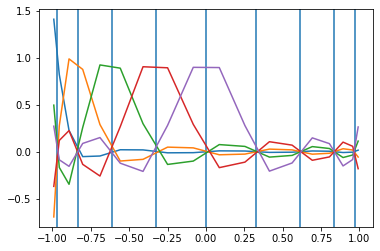

In [147]:
e0,e1,e2 = build_p(p)

In [148]:
np.linalg.norm(e0), np.linalg.norm(e1), np.linalg.norm(e2)

(2.4631366211183276e-14, 2.4827923822798653e-14, 4.860577789261549e-14)

In [141]:
np.linalg.norm(e1)

2.4827923822798653e-14

In [142]:
np.linalg.norm(e2)

4.860577789261549e-14

-----

In [42]:
def get_A(k1,k2):
    A = np.zeros((2*len(pipe.t), 2*len(pipe.t)), dtype=np.float64)
    A[:len(pipe.t),:len(pipe.t)] = np.eye(len(pipe.t)) + np.real(k1 + k2)
    A[:len(pipe.t),len(pipe.t):] = np.imag(k2 - k1)
    A[len(pipe.t):,:len(pipe.t)] = np.imag(k1 + k2)
    A[len(pipe.t):,len(pipe.t):] = np.eye(len(pipe.t)) + np.real(k1 - k2)
    return A

A = get_A(pipe.mat_vec.K1, pipe.mat_vec.K2)
A_corrected = get_A(k1_corrected, k2_corrected)

In [37]:
np.log10(np.linalg.cond(A_corrected))

9.927902762549325

In [38]:
np.log10(np.linalg.cond(A))

13.283374546585339

In [15]:
weight2coeff = np.linalg.solve(np.vander(p.normalize(p.t,with_affine=True),N=p.n),np.eye(p.n))
coef2interp = np.vander(p.t_refined_normalized,N=p.n)
interp = coef2interp @ weight2coeff

In [89]:
interp[0]

array([ 1.41362396+1.48026684e-16j, -0.7022078 -5.44298753e-16j,
        0.50763977+1.19908464e-15j, -0.38740798-2.53533072e-15j,
        0.29525117+2.12159671e-15j, -0.21827182-4.16689144e-16j,
        0.15200944-3.91406920e-17j, -0.09521831+1.31615354e-16j,
        0.04839565-9.64793167e-17j, -0.01381408+3.16152378e-17j])

In [96]:
np.max(np.abs(interp - p.density_interp))

3.677613769070831e-14

In [76]:
np.log10(np.linalg.cond(A)), np.log10(np.linalg.cond(A_corrected))

(14.619327922842363, 14.313997439618843)

In [32]:
np.log10(np.linalg.cond(A)), np.log10(np.linalg.cond(A_corrected))

(14.619327922842363, 20.936047182612686)

In [21]:
new_mat_vec = mat_vec_constructor(pipe)

In [22]:
new_mat_vec.K1 = k1_corrected
new_mat_vec.K2 = k2_corrected

In [23]:
def build_omegas(pipe, A, tol=REQUIRED_TOL):
    return np.array([
        compute_omega(pipe, pipe.boundary_value(i),A,tol) 
        for i in range(pipe.n_flows)])
    
def compute_omega(pipe, H, A, tol=REQUIRED_TOL, max_iter=None):

    tol = GMRES_TOL if tol is None else tol
    max_iter = GMRES_MAX_ITER if max_iter is None else max_iter
    b = np.concatenate((H.real, H.imag))

    omega_sep, _ = gmres(A, b, atol=0, tol=tol, restart=RESTART, maxiter=max_iter)

    omega = omega_sep[:pipe.n_pts] + 1j*omega_sep[pipe.n_pts:]
    return omega

In [24]:
pipe.build_omegas()

In [1]:
o = pipe.omegas[0]

NameError: name 'pipe' is not defined

In [26]:
omega_corrected = compute_omega(pipe,pipe.boundary_value(0), A_corrected)

In [29]:
x_min, x_max = np.min(pipe.t.real), np.max(pipe.t.real)
y_min, y_max = np.min(pipe.t.imag), np.max(pipe.t.imag)

In [ ]:
xs = np.linspace(x_min, x_max, 100)

In [ ]:
class callback:
    def __init__(self):
        self.pr_norms = []
    
    def __call__(self, x):
        self.pr_norms.append(x)

In [25]:
from scipy.linalg import solve

In [26]:
help(solve)

Help on function solve in module scipy.linalg._basic:

solve(a, b, sym_pos=False, lower=False, overwrite_a=False, overwrite_b=False, check_finite=True, assume_a='gen', transposed=False)
    Solves the linear equation set ``a * x = b`` for the unknown ``x``
    for square ``a`` matrix.
    
    If the data matrix is known to be a particular type then supplying the
    corresponding string to ``assume_a`` key chooses the dedicated solver.
    The available options are
    
    ===================  ========
     generic matrix       'gen'
     symmetric            'sym'
     hermitian            'her'
     positive definite    'pos'
    ===================  ========
    
    If omitted, ``'gen'`` is the default structure.
    
    The datatype of the arrays define which solver is called regardless
    of the values. In other words, even when the complex array entries have
    precisely zero imaginary parts, the complex solver will be called based
    on the data type of the array.
    
  